# The Data

The work performed herein was built off of the shoulders of giants, the original project that created the dataset and labeled the images. Here follows an excerpt from their site describing the data.

> [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.4002935.svg)](https://doi.org/10.5281/zenodo.4002935)
>__Project member(s)__:\
>Topher Allen; Zach Anderson; Berlin Chen; Ameya Daigavane; Annie Didier; Marko Green; Paul Horton; Hannah Kerner; Lauren Klein; Benjamin Kolber; Ellie Kuang; Kyle Kung; Jake Lee; Justin Martia; Brian Milch; James Montgomery; Kyle Pearson; Sanjna Ravichandar; Arun Viswanathan; Caleb Wagner; Amruta Yelamanchili; Brandon Zhao
>
>__Abstract__:\
>This dataset contains a total of 64,947 landmark images that were detected and extracted from HiRISE browse images, spanning 232 separate source images.
>
>This set was formed from 10,815 original landmarks. Each original landmark was cropped to a square bounding box that included the full extent of the landmark plus a 30-pixel margin to the left, right, top, and bottom. Each landmark was then resized to 227x227 pixels. 9,022 of these images were then augmented to generate 6 additional landmarks using the following methods:
>
>90 degrees clockwise rotation
>180 degrees clockwise rotation
>270 degrees clockwise rotation
>Horizontal flip
>Vertical flip
>Random brightness adjustment
>The remaining 1,793 images were not augmented. Combining these with the 7*9,022 images, gives a total of 64,947 separate images.
>
> __Contents__:
>- map-proj-v3_2/: Directory containing individual cropped landmark images
>- labels-map-proj-v3_2.txt: Class labels (ids) for each landmark image. File includes two columns separated by a space: filename, class_id
>- labels-map-proj-v3_2_train_val_test.txt: Includes train/test/val labels and upsampling used for trained model. File includes three columns separated by a space: filename, class_id, set
>- landmarks_map-proj-v3_2_classmap.csv: Dictionary that maps class ids to semantic names
>
> __Class Discussion__:\
>We give a discussion of the various landmarks that make up our classes.
>
>Bright dune and dark dune are two sand dune classes found on Mars. Dark dunes are completely defrosted, whereas bright dunes are not. Bright dunes are generally bright due to overlying frost and can exhibit black spots where parts of the dune are defrosting.
>
>The crater class consists of crater images in which the diameter of the crater is greater than or equal to 1/5 the width of the image and the circular rim is visible for at least half the crater's circumference.
>
>The slope streak class consists of images of dark flow-like features on slopes. These features are believed to be formed by a dry process in which overlying (bright) dust slides down a slope and reveals a darker sub-surface.
>
>Impact ejecta refers to material that is blasted out from the impact of a meteorite or the eruption of a volcano. We also include cases in which the impact cleared away overlying dust, exposing the underlying surface. In some cases, the associated crater may be too small to see. Impact ejecta can also include lava that spilled out from the impact (blobby ("lobate") instead of blast-like), more like an eruption (triggered by the impact). Impact ejecta can be isolated, or they can form in clusters when the impactor breaks up into multiple fragments.
>
>Spiders and Swiss cheese are phenomena that occur in the south polar region of Mars. Spiders have a central pit with radial troughs, and they are believed to form as a result of sublimation of carbon dioxide ice. This process can produce mineral deposits on top, which look like dark or light dust that highlights cracks in the CO2 ice. Spiders can resemble impact ejecta due to their radial troughs, but impact ejecta tends to have straight radial jets that fade as they get farther from the center. The spider class also includes fan-like features that form when a geyser erupts through the CO2 layer and the material is blown by the wind away from the cracks. Fans are typically unidirectional (following the wind direction), whereas impact ejecta often extends in multiple directions. Swiss cheese is a terrain type that consists of pits that are formed when the sun heats the ice making it sublimate (change solid to gas).
>
>Other is a catch-all class that contains images that fit none of the defined classes of interest. This class makes up the majority of our data set.


# Business Understanding

Space exploration and understanding has been growing over the last few decades with the spark being lit during the space race during the latter half of the 20th century. After the end of the Apollo space program, man's venture into space has been relegated to low earth orbit missions.  

Unmanned missions have since had many a success story such as the Voyager 2 going interstellar in 2018, over 40 years after its launch. The future of space exploration is going to be handled by such manned missions for the foreseeable future. However, being physically on site isn't the only way to explore space.  

For centuries, man has looked up at the night sky to find out more about our celestial neighbors. With improvements in technologies our ability to gather data through telescopes and cameras has improved significantly and the value provided by telescopes in space has been immeasurable. The James Webb (infrared) telescope was launched in December 2021 and hopes to view objects too old, distant, and faint for the Hubble Space Telescope.

Pointing the telescope and gathering data is only the first step. Being able to parse terabytes, petabytes or even yottabytes of data manually is a nigh impossible task, a task computer vision is especially suited for. Being able to identify interesting features can help us whittle down potential candidates to explore 'in-person' and in the long run help mitigate losses.

Interest in space exploration has seen a resurgence with private enterprise taking an interest. Although this project specifically looks at the Mars topography, similar techniques can be applied to any celestial body, or even to our home planet.

# Overview
We shall be using images captured from the HiRISE camera system on board the Mars Reconnaisance Orbiter which was built under direction from University of Arizona's Lunar and Planetary Laboratory. Following is an excerpt from the [University of Arizona website](https://www.lpl.arizona.edu/missions/hirise-mro).

>The __Hi__gh __R__esolution __I__maging __S__cience __E__xperiment (HiRISE) onboard the Mars Reconnaissance Orbiter, is the most powerful camera ever sent to another planet. The resolution of the camera allows us to see the Red Planet in amazing detail, and lets other missions, like the Mars Science Laboratory, find a safe place to land and carry out amazing science. The operations center, which includes not only observation planning, but the execution of commands sent to the spacecraft along with actual image processing, is located within LPL at the University of Arizona.

We shall be building off of the work performed by the original team. The dataset comes pre-augmented and segmented into training, validation and test sets. The test side will be set aside to ascertain effectiveness of our final model. The training set will be used to train the model and the validation scores on the validation set will be used as a metric to pick our model, specifically our validation loss.

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
tf.random.set_seed(
    42
)
import seaborn as sns

# tf_chkpt_path = 'tf_Adam_checkpoints/'

In [4]:
from src.helperFunctions import display_model_trainTestGraphs

## Training Set

In [5]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=225,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 48979 images belonging to 8 classes.


## Validation Set

In [6]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


## Test Set

In [7]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=8,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 1793 images belonging to 8 classes.


## Modeling Callbacks

In [8]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-8,
                           verbose=1,
                           patience = 10,
                           restore_best_weights=True,
                           mode='min')

epochs_to_train = 100

# Modeling

We are going to be using a Convolutional Neural Networks tensorflow model.\
They are the model of choice as they are best suited to our problem of image classfication. We will be using `relu` as our activation function.\
Since we have 8 classes as part of our classification model, we will be using `softmax` as the activation function of the final layer.

## Model 1 - Simple CNN - First Simple Model

In [10]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 8)                 3211272   
                                                                 
Total params: 3,211,592
Trainable params: 3,211,592
Non-trainable params: 0
_________________________________________________________________


In [11]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1
                    )

Epoch 1/100
218/218 [==============================] - 39s 161ms/step - loss: 1.1503 - accuracy: 0.8104 - precision: 0.8174 - recall: 0.7930 - val_loss: 0.7679 - val_accuracy: 0.7926 - val_precision: 0.7978 - val_recall: 0.7856
Epoch 2/100
218/218 [==============================] - 35s 160ms/step - loss: 0.5928 - accuracy: 0.8275 - precision: 0.8382 - recall: 0.8161 - val_loss: 0.8415 - val_accuracy: 0.7922 - val_precision: 0.7981 - val_recall: 0.7857
Epoch 3/100
218/218 [==============================] - 35s 161ms/step - loss: 0.5198 - accuracy: 0.8414 - precision: 0.8533 - recall: 0.8282 - val_loss: 0.7708 - val_accuracy: 0.7938 - val_precision: 0.8075 - val_recall: 0.7653
Epoch 4/100
218/218 [==============================] - 35s 160ms/step - loss: 0.4483 - accuracy: 0.8600 - precision: 0.8709 - recall: 0.8476 - val_loss: 0.8076 - val_accuracy: 0.7911 - val_precision: 0.8060 - val_recall: 0.7668
Epoch 5/100
218/218 [==============================] - 35s 160ms/step - loss: 0.3860 - a

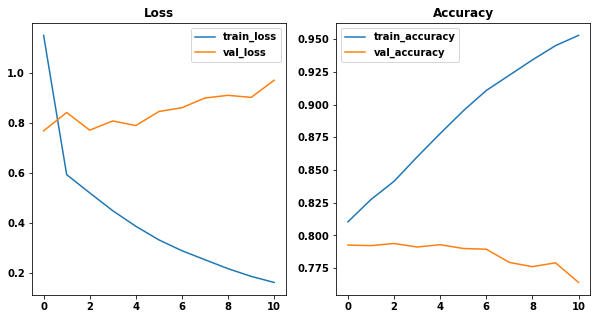

In [12]:
display_model_trainTestGraphs(results)

Our first simple model, employed a single convolution layer and pooling pair. 

Validation loss from the very beginning never improved and overall accuracy went down. The model is unable to pick up on details and features of the images. Its a good starting point but we need to increase complexity of our models.

## Model 2
Adding a few more convolution+pool layers and a fully connected final layer

In [13]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 225, 225, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 110, 110, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 64)      

In [14]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/100
100/100 [==============================] - 18s 164ms/step - loss: 0.7895 - accuracy: 0.8072 - precision_1: 0.8142 - recall_1: 0.7942 - val_loss: 0.8038 - val_accuracy: 0.7816 - val_precision_1: 0.7932 - val_recall_1: 0.7528
Epoch 2/100
100/100 [==============================] - 16s 162ms/step - loss: 0.6042 - accuracy: 0.8336 - precision_1: 0.8472 - recall_1: 0.8182 - val_loss: 0.7303 - val_accuracy: 0.8019 - val_precision_1: 0.8102 - val_recall_1: 0.7775
Epoch 3/100
100/100 [==============================] - 17s 167ms/step - loss: 0.5141 - accuracy: 0.8480 - precision_1: 0.8641 - recall_1: 0.8313 - val_loss: 0.7442 - val_accuracy: 0.7819 - val_precision_1: 0.8035 - val_recall_1: 0.7400
Epoch 4/100
100/100 [==============================] - 16s 163ms/step - loss: 0.4537 - accuracy: 0.8627 - precision_1: 0.8778 - recall_1: 0.8464 - val_loss: 0.7702 - val_accuracy: 0.7862 - val_precision_1: 0.8032 - val_recall_1: 0.7638
Epoch 5/100
100/100 [==============================] - 1

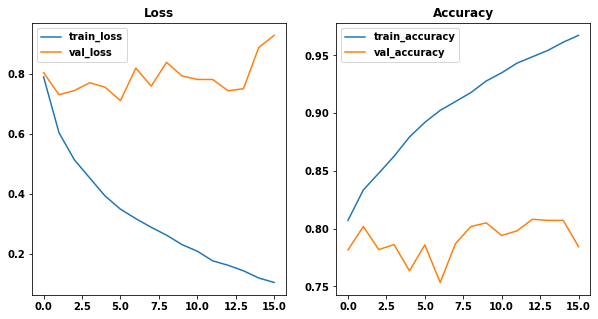

In [15]:
display_model_trainTestGraphs(results)

In [16]:
# results.model.save(tf_chkpt_path+'Model_2')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_2\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_2\assets


Although validation loss decreased initially, however, overfitting started early. We can start incrementally increasing complexity.

## Model 3

Adding an additional dense layers at end

In [17]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 64)      

In [18]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/100
100/100 [==============================] - 16s 148ms/step - loss: 0.7854 - accuracy: 0.8124 - precision_2: 0.8226 - recall_2: 0.7977 - val_loss: 0.8051 - val_accuracy: 0.7947 - val_precision_2: 0.8004 - val_recall_2: 0.7797
Epoch 2/100
100/100 [==============================] - 15s 145ms/step - loss: 0.5956 - accuracy: 0.8348 - precision_2: 0.8514 - recall_2: 0.8164 - val_loss: 0.8033 - val_accuracy: 0.7937 - val_precision_2: 0.8017 - val_recall_2: 0.7747
Epoch 3/100
100/100 [==============================] - 14s 143ms/step - loss: 0.4896 - accuracy: 0.8582 - precision_2: 0.8724 - recall_2: 0.8447 - val_loss: 0.7780 - val_accuracy: 0.7894 - val_precision_2: 0.8016 - val_recall_2: 0.7728
Epoch 4/100
100/100 [==============================] - 15s 148ms/step - loss: 0.4289 - accuracy: 0.8768 - precision_2: 0.8892 - recall_2: 0.8635 - val_loss: 0.7096 - val_accuracy: 0.8031 - val_precision_2: 0.8171 - val_recall_2: 0.7847
Epoch 5/100
100/100 [==============================] - 1

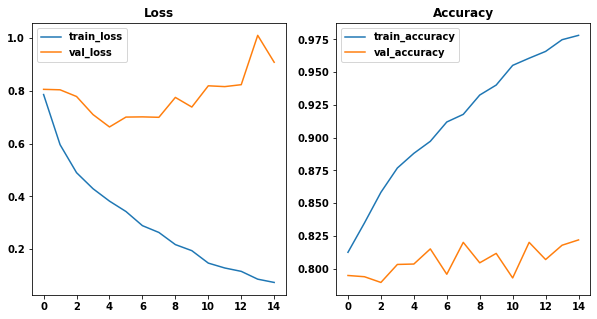

In [19]:
display_model_trainTestGraphs(results)

In [20]:
results.model.save(tf_chkpt_path+'Model_3')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_3\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_3\assets


No appreciable reduction in loss and overfitting set in early again. However, we also recorded our lowest every validation loss. Trying a few different variations of increasing complexity.

## Model 4: Increasing depth of our Neural Network

Adding an extra layer of conv+maxpooling

In [21]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 64)      

In [22]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/100
100/100 [==============================] - 16s 147ms/step - loss: 0.7641 - accuracy: 0.8112 - precision_3: 0.8227 - recall_3: 0.8004 - val_loss: 0.8424 - val_accuracy: 0.7703 - val_precision_3: 0.7939 - val_recall_3: 0.7247
Epoch 2/100
100/100 [==============================] - 14s 142ms/step - loss: 0.5914 - accuracy: 0.8365 - precision_3: 0.8554 - recall_3: 0.8180 - val_loss: 0.7986 - val_accuracy: 0.7747 - val_precision_3: 0.7990 - val_recall_3: 0.7566
Epoch 3/100
100/100 [==============================] - 14s 144ms/step - loss: 0.4935 - accuracy: 0.8572 - precision_3: 0.8754 - recall_3: 0.8416 - val_loss: 0.7214 - val_accuracy: 0.7994 - val_precision_3: 0.8181 - val_recall_3: 0.7716
Epoch 4/100
100/100 [==============================] - 14s 143ms/step - loss: 0.4332 - accuracy: 0.8741 - precision_3: 0.8878 - recall_3: 0.8588 - val_loss: 0.6623 - val_accuracy: 0.7891 - val_precision_3: 0.8270 - val_recall_3: 0.7350
Epoch 5/100
100/100 [==============================] - 1

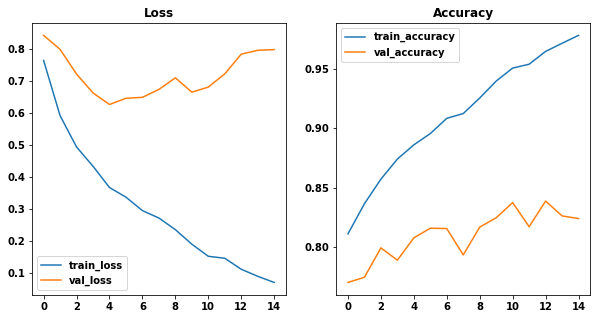

In [23]:
display_model_trainTestGraphs(results)

In [24]:
results.model.save(tf_chkpt_path+'Model_4')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_4\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_4\assets


In terms of validation loss, this is our best performing model so far, despite again overfitting setting in early. Increasing convolutions definitely seems to be the right direction to go in. 
However, something to keep in mind, our Dummy Classifier can perform with an accuracy of about 81%, this model is barely crossing 83.5%.   
One way we can help prevent overfitting is to employ dropout layers.

## Model 4a: Adding a dropout layer and furthering depth

To help reduce overfitting adding a dropout layer at dense layer level and increasing the number of convolutions before pooling. I also increase the number of neurons on the fully connected layers.

In [25]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 conv2d_14 (Conv2D)          (None, 51, 51, 64)       

In [26]:
results = model.fit(train_generator,
                    callbacks=early_stop,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/100
100/100 [==============================] - 18s 166ms/step - loss: 0.8088 - accuracy: 0.8148 - precision_4: 0.8225 - recall_4: 0.7845 - val_loss: 0.8491 - val_accuracy: 0.7872 - val_precision_4: 0.8088 - val_recall_4: 0.7481
Epoch 2/100
100/100 [==============================] - 17s 167ms/step - loss: 0.6012 - accuracy: 0.8331 - precision_4: 0.8595 - recall_4: 0.8068 - val_loss: 0.7567 - val_accuracy: 0.7925 - val_precision_4: 0.8072 - val_recall_4: 0.7706
Epoch 3/100
100/100 [==============================] - 16s 164ms/step - loss: 0.5236 - accuracy: 0.8559 - precision_4: 0.8738 - recall_4: 0.8365 - val_loss: 0.7533 - val_accuracy: 0.7684 - val_precision_4: 0.8145 - val_recall_4: 0.7150
Epoch 4/100
100/100 [==============================] - 16s 163ms/step - loss: 0.4444 - accuracy: 0.8725 - precision_4: 0.8883 - recall_4: 0.8548 - val_loss: 0.6616 - val_accuracy: 0.8000 - val_precision_4: 0.8291 - val_recall_4: 0.7641
Epoch 5/100
100/100 [==============================] - 1

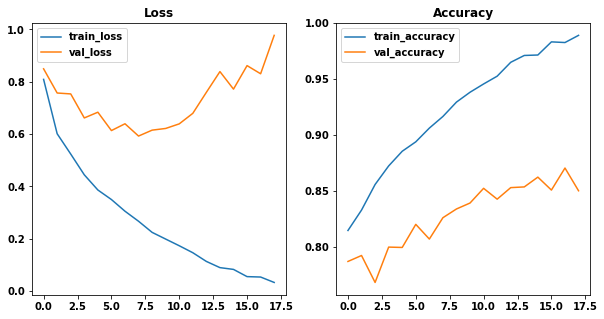

In [27]:
display_model_trainTestGraphs(results)

In [28]:
results.model.save(tf_chkpt_path+'Model_5_Dropout_02')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_5_Dropout_02\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_5_Dropout_02\assets


Validation loss for the first time dipped below 0.6 and the model's best recorded accuracy crossed 85%. The dropout layer definitely helped. Lets see if increasing the strength of our dropout layer makes an improvement.

## Model 5b: Adding a dropout layer and furthering depth

In [29]:
# Increasing dropout rate
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 conv2d_20 (Conv2D)          (None, 51, 51, 64)       

In [30]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/100
100/100 [==============================] - 17s 167ms/step - loss: 0.8624 - accuracy: 0.8112 - precision_5: 0.8187 - recall_5: 0.7765 - val_loss: 0.8499 - val_accuracy: 0.7931 - val_precision_5: 0.7931 - val_recall_5: 0.7931
Epoch 2/100
100/100 [==============================] - 16s 163ms/step - loss: 0.7165 - accuracy: 0.8207 - precision_5: 0.8359 - recall_5: 0.8033 - val_loss: 1.0086 - val_accuracy: 0.7356 - val_precision_5: 0.8172 - val_recall_5: 0.4666
Epoch 3/100
100/100 [==============================] - 16s 163ms/step - loss: 0.6017 - accuracy: 0.8364 - precision_5: 0.8613 - recall_5: 0.8077 - val_loss: 0.8009 - val_accuracy: 0.7772 - val_precision_5: 0.7999 - val_recall_5: 0.7169
Epoch 4/100
100/100 [==============================] - 16s 163ms/step - loss: 0.5092 - accuracy: 0.8555 - precision_5: 0.8760 - recall_5: 0.8346 - val_loss: 0.6503 - val_accuracy: 0.8037 - val_precision_5: 0.8274 - val_recall_5: 0.7775
Epoch 5/100
100/100 [==============================] - 1

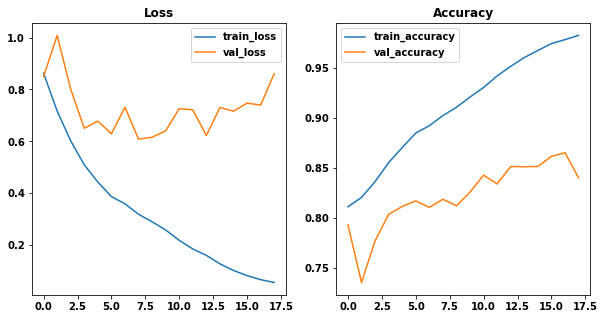

In [31]:
display_model_trainTestGraphs(results)

In [32]:
results.model.save(tf_chkpt_path+'Model_5_Dropout_05')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_5_Dropout_05\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_5_Dropout_05\assets


The higher level of dropout has made a pretty discernable improvement in our validation loss. After epoch 13, loss started to increase again.

Still with a validation loss of about 0.61, the model at epoch 9 is our best performing model yet.

## Model 6 - VGG-esque

In 2014, Karen Simonyan, Andrew Zissermanren wrote a paper on _Very Deep Convolutional Networks for Large-Scale Image Recognition_ using 16/19 layer variations of the same architecture called [VGG](https://arxiv.org/abs/1409.1556). This architecture has seen tremendous success in a variety of different arenas.\
Taking a leaf from their book and convolutional layers.

In [33]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 conv2d_25 (Conv2D)          (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 128)      

In [34]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/100
100/100 [==============================] - 43s 384ms/step - loss: 0.9079 - accuracy: 0.8157 - precision_6: 0.8152 - recall_6: 0.7497 - val_loss: 0.8804 - val_accuracy: 0.7909 - val_precision_6: 0.7909 - val_recall_6: 0.7909
Epoch 2/100
100/100 [==============================] - 41s 408ms/step - loss: 0.7849 - accuracy: 0.8183 - precision_6: 0.8184 - recall_6: 0.8169 - val_loss: 0.9133 - val_accuracy: 0.7828 - val_precision_6: 0.7828 - val_recall_6: 0.7828
Epoch 3/100
100/100 [==============================] - 38s 376ms/step - loss: 0.7926 - accuracy: 0.8157 - precision_6: 0.8157 - recall_6: 0.8157 - val_loss: 0.8418 - val_accuracy: 0.7947 - val_precision_6: 0.7947 - val_recall_6: 0.7947
Epoch 4/100
100/100 [==============================] - 37s 372ms/step - loss: 0.7525 - accuracy: 0.8209 - precision_6: 0.8210 - recall_6: 0.8184 - val_loss: 0.8920 - val_accuracy: 0.7916 - val_precision_6: 0.7916 - val_recall_6: 0.7916
Epoch 5/100
100/100 [==============================] - 3

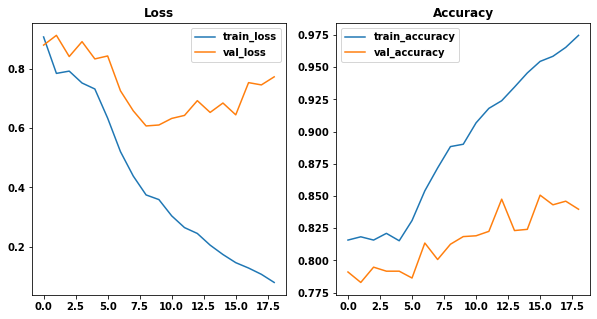

In [35]:
display_model_trainTestGraphs(results)

In [36]:
results.model.save(tf_chkpt_path+'Model_6_VGG_prototype')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_6_VGG_prototype\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_6_VGG_prototype\assets


Severe overfitting with no discernable improvement in validaiton losses or accuracy. Maybe 

## Model 7: Reducing conv layers per set

In [41]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 26, 26, 128)     

In [42]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/100
100/100 [==============================] - 24s 215ms/step - loss: 0.9011 - accuracy: 0.8101 - precision_8: 0.8181 - recall_8: 0.7551 - val_loss: 0.8619 - val_accuracy: 0.7912 - val_precision_8: 0.7912 - val_recall_8: 0.7912
Epoch 2/100
100/100 [==============================] - 20s 203ms/step - loss: 0.7551 - accuracy: 0.8187 - precision_8: 0.8295 - recall_8: 0.8079 - val_loss: 0.8846 - val_accuracy: 0.7828 - val_precision_8: 0.7904 - val_recall_8: 0.7544
Epoch 3/100
100/100 [==============================] - 20s 203ms/step - loss: 0.5845 - accuracy: 0.8374 - precision_8: 0.8679 - recall_8: 0.8096 - val_loss: 0.7323 - val_accuracy: 0.8025 - val_precision_8: 0.8194 - val_recall_8: 0.7856
Epoch 4/100
100/100 [==============================] - 21s 205ms/step - loss: 0.4737 - accuracy: 0.8646 - precision_8: 0.8858 - recall_8: 0.8428 - val_loss: 0.6503 - val_accuracy: 0.7934 - val_precision_8: 0.8192 - val_recall_8: 0.7703
Epoch 5/100
100/100 [==============================] - 2

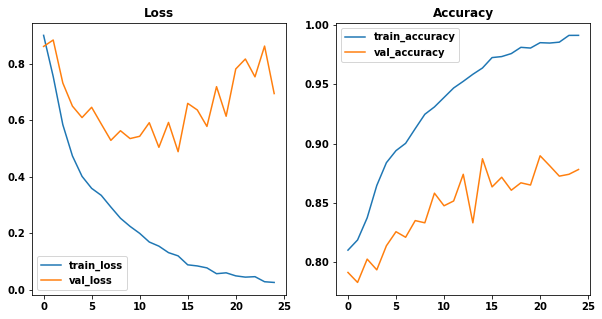

In [43]:
display_model_trainTestGraphs(results)

In [44]:
results.model.save(tf_chkpt_path+'Model_7a_VGG_1convPer')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_7a_VGG_1convPer\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_7a_VGG_1convPer\assets


Validation loss further reduced, with the lowest recorded 0.5598. And more importantly its holding and not drastically increasing again again.

### Reducing learning rate

Going to rerun the previous model, but reducing learning rate. Intuition being a more granular descent might help with the erratic validation scores.

In [45]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])


model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 26, 26, 128)     

In [46]:
results = model.fit(train_generator,
                    steps_per_epoch=100,  # Number of training samples to pull per epoch
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

Epoch 1/100
100/100 [==============================] - 23s 227ms/step - loss: 0.9053 - accuracy: 0.8094 - precision_9: 0.8185 - recall_9: 0.7443 - val_loss: 0.8773 - val_accuracy: 0.7872 - val_precision_9: 0.7874 - val_recall_9: 0.7872
Epoch 2/100
100/100 [==============================] - 22s 223ms/step - loss: 0.7249 - accuracy: 0.8194 - precision_9: 0.8322 - recall_9: 0.8069 - val_loss: 0.8154 - val_accuracy: 0.7773 - val_precision_9: 0.7913 - val_recall_9: 0.7670
Epoch 3/100
100/100 [==============================] - 22s 223ms/step - loss: 0.6296 - accuracy: 0.8350 - precision_9: 0.8577 - recall_9: 0.8104 - val_loss: 0.7752 - val_accuracy: 0.7859 - val_precision_9: 0.8075 - val_recall_9: 0.7661
Epoch 4/100
100/100 [==============================] - 23s 232ms/step - loss: 0.5655 - accuracy: 0.8497 - precision_9: 0.8692 - recall_9: 0.8277 - val_loss: 0.7598 - val_accuracy: 0.7853 - val_precision_9: 0.8081 - val_recall_9: 0.7586
Epoch 5/100
100/100 [==============================] - 2

Epoch 36/100
100/100 [==============================] - 22s 224ms/step - loss: 0.1135 - accuracy: 0.9640 - precision_9: 0.9658 - recall_9: 0.9616 - val_loss: 0.6185 - val_accuracy: 0.8478 - val_precision_9: 0.8520 - val_recall_9: 0.8445
Epoch 36: early stopping


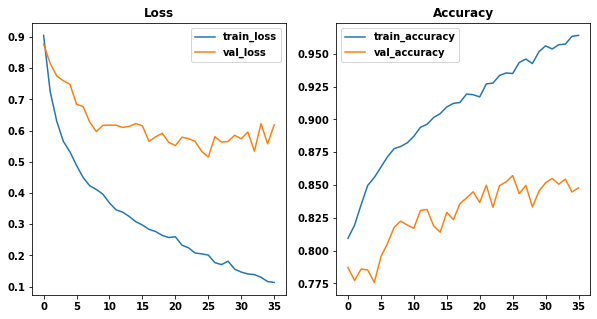

In [47]:
display_model_trainTestGraphs(results)

In [48]:
results.model.save(tf_chkpt_path+'Model_7a_VGG_1convPer')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_7a_VGG_1convPer\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_7a_VGG_1convPer\assets


Learning rate didn't have the desired/expected outcome. Althought validation losses seem to have a smoother descent

### Increasing steps per epoch

Keeping the same reduced learning rate but increasing the number of training steps per epoch

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 26, 26, 128)    

Epoch 24/100
200/200 [==============================] - 41s 207ms/step - loss: 0.0585 - accuracy: 0.9815 - precision_10: 0.9826 - recall_10: 0.9805 - val_loss: 0.6416 - val_accuracy: 0.8498 - val_precision_10: 0.8542 - val_recall_10: 0.8456
Epoch 25/100
200/200 [==============================] - 41s 205ms/step - loss: 0.0461 - accuracy: 0.9856 - precision_10: 0.9863 - recall_10: 0.9849 - val_loss: 0.7193 - val_accuracy: 0.8567 - val_precision_10: 0.8619 - val_recall_10: 0.8534
Epoch 26/100
200/200 [==============================] - 41s 206ms/step - loss: 0.0416 - accuracy: 0.9866 - precision_10: 0.9872 - recall_10: 0.9859 - val_loss: 0.7752 - val_accuracy: 0.8573 - val_precision_10: 0.8602 - val_recall_10: 0.8550
Epoch 26: early stopping


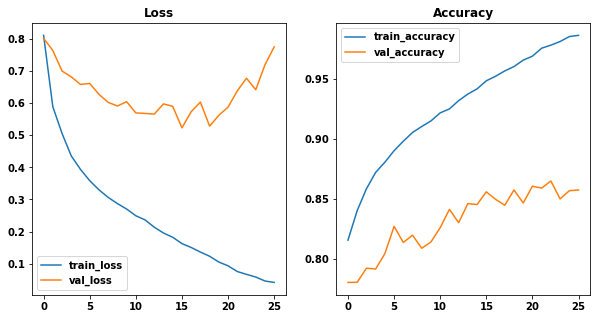

In [49]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=200,  # Number of training samples to pull per epoch
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )


display_model_trainTestGraphs(results)

Increasing the number of training samples has had a positive impact. More training examples per epoch makes for a more informed update on the weights. Overall validation loss has shown a smoother descent but also maintains around 0.55.

Lowest recorded val_loss of 0.5434

## Model 8 - Adding 1 additional convolution at a time

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 26, 26, 128)    

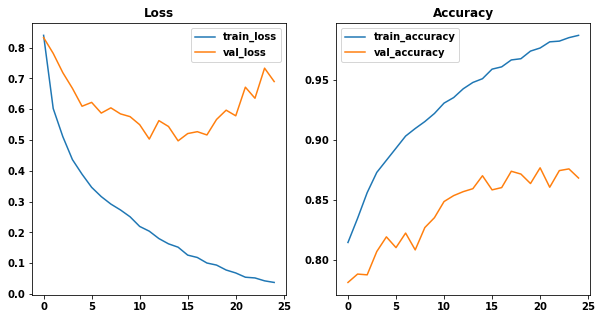

In [50]:
# one additional convolution at 512 layer
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [51]:
results.model.save(tf_chkpt_path+'Model_8')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_8\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_8\assets


Best performing model yet. Val loss was hovering around 0.5

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 26, 26, 128)    

300/300 [==============================] - 57s 183ms/step - loss: 0.8349 - accuracy: 0.8140 - precision_12: 0.8214 - recall_12: 0.7756 - val_loss: 0.8376 - val_accuracy: 0.7812 - val_precision_12: 0.7896 - val_recall_12: 0.7619


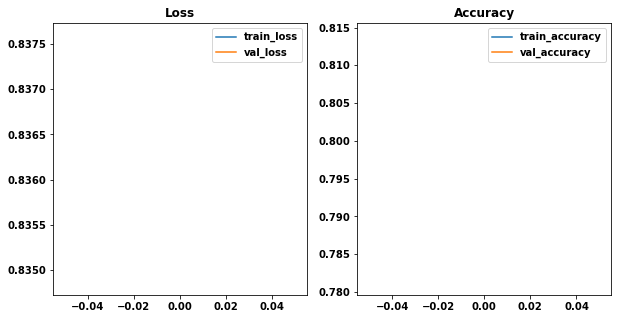

In [52]:
# one additional convolution at 512, 256 layer
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    steps_per_epoch=300,  # Number of training samples to pull per epoch
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [53]:
results.model.save(tf_chkpt_path+'Model_8')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_8\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_8\assets


## Model 9

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 26, 26, 128)    

218/218 [==============================] - 58s 265ms/step - loss: 0.0752 - accuracy: 0.9748 - precision_13: 0.9758 - recall_13: 0.9737 - val_loss: 0.5965 - val_accuracy: 0.8754 - val_precision_13: 0.8782 - val_recall_13: 0.8738
Epoch 23/100
218/218 [==============================] - 58s 265ms/step - loss: 0.0651 - accuracy: 0.9779 - precision_13: 0.9789 - recall_13: 0.9768 - val_loss: 0.5205 - val_accuracy: 0.8782 - val_precision_13: 0.8816 - val_recall_13: 0.8756
Epoch 24/100
218/218 [==============================] - 58s 265ms/step - loss: 0.0607 - accuracy: 0.9793 - precision_13: 0.9802 - recall_13: 0.9787 - val_loss: 0.4997 - val_accuracy: 0.8811 - val_precision_13: 0.8850 - val_recall_13: 0.8791
Epoch 25/100
218/218 [==============================] - 58s 265ms/step - loss: 0.0540 - accuracy: 0.9807 - precision_13: 0.9816 - recall_13: 0.9800 - val_loss: 0.6360 - val_accuracy: 0.8787 - val_precision_13: 0.8803 - val_recall_13: 0.8783
Epoch 26/100
218/218 [===========================

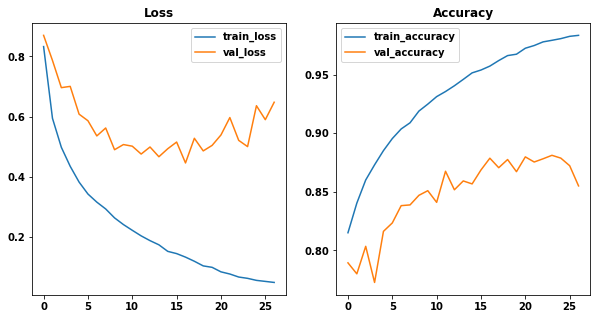

In [54]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.3))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [55]:
results.model.save(tf_chkpt_path+'Model_9')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_9\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_9\assets


Best numbers yet. Val_loss of 0.42

## Model 10

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 conv2d_77 (Conv2D)          (None, 51, 51, 128)     

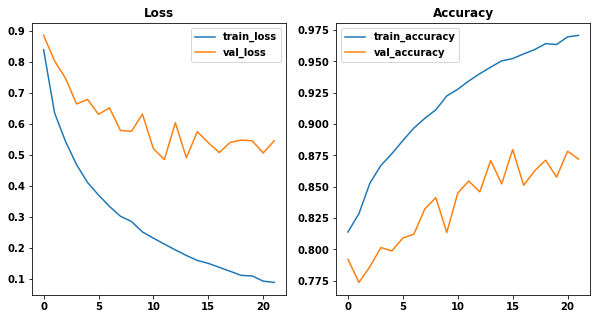

In [56]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [57]:
results.model.save(tf_chkpt_path+'Model_10')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_10\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_10\assets


Best numbers yet. Val_loss of 0.40

## Model 11 - one more 512 conv - bad

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 conv2d_85 (Conv2D)          (None, 51, 51, 128)     

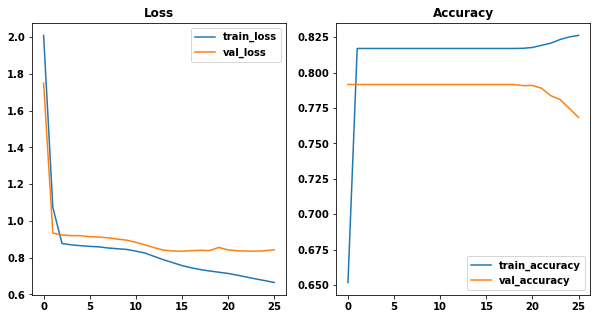

In [58]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=1e-6),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [59]:
results.model.save(tf_chkpt_path+'Model_11')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_11\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_11\assets


## Model 12

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (None, 110, 110, 64)      9280      
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 conv2d_94 (Conv2D)          (None, 51, 51, 128)     

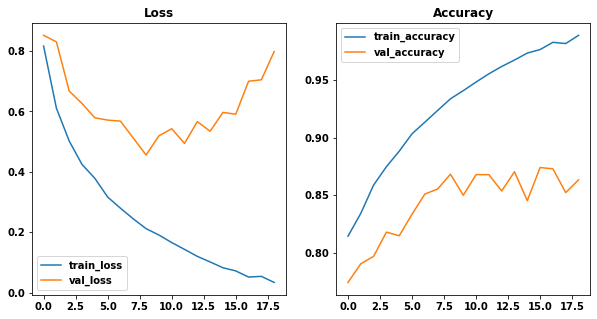

In [60]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))



model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [61]:
results.model.save(tf_chkpt_path+'Model_12')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_12\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_12\assets


## Model 14 - MOAR COMPLEXITY!

changed first layers filter to 32
3 dropout layers
- after of all convolution sets
- on first dense layer
- on second dense layer

In [11]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 225, 225, 32)      320       
                                                                 
 batch_normalization_8 (Batc  (None, 225, 225, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 batch_normalization_9 (Batc  (None, 110, 110, 64)     256       
 hNormalization)                                                 
                                                      

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/batch_normalization_9/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\saads\AppData\Local\Temp\ipykernel_17196\1325078344.py", line 49, in <cell line: 49>
      results = model.fit(train_generator,
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 594, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 571, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_1/batch_normalization_9/FusedBatchNormV3'
Detected at node 'sequential_1/batch_normalization_9/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\saads\AppData\Local\Temp\ipykernel_17196\1325078344.py", line 49, in <cell line: 49>
      results = model.fit(train_generator,
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 594, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 571, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_1/batch_normalization_9/FusedBatchNormV3'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[225,64,110,110] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/batch_normalization_9/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[assert_less_equal/Assert/AssertGuard/pivot_f/_13/_45]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[225,64,110,110] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/batch_normalization_9/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_6076]

In [ ]:
results.model.save(tf_chkpt_path+'Model_14')

Removing batch normalization layers

In [12]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(256, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 225, 225, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 53, 53, 128)       73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 51, 51, 128)      

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_2/max_pooling2d_10/MaxPool/MaxPoolGrad' defined at (most recent call last):
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\saads\AppData\Local\Temp\ipykernel_17196\3283301896.py", line 49, in <cell line: 49>
      results = model.fit(train_generator,
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\saads\anaconda3\envs\tfGPU\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_2/max_pooling2d_10/MaxPool/MaxPoolGrad'
OOM when allocating tensor with shape[225,32,225,225] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_2/max_pooling2d_10/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8107]

In [ ]:
results.model.save(tf_chkpt_path+'Model_14b')

## Model 16 - More regularization. Reducing complexity to combat overfitting

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

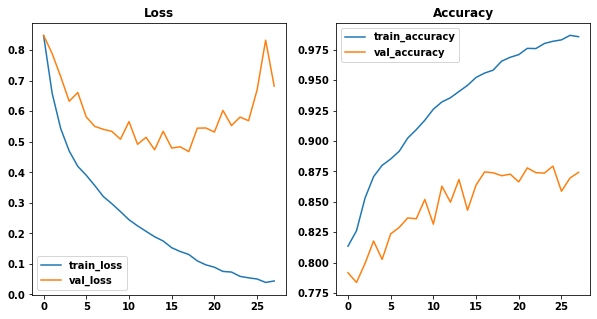

In [10]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                       kernel_size=3,
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(3,3))

model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

# model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

# model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(512, 3, activation='relu'))
model.add(layers.Conv2D(512, 3, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))


model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy', Precision(), Recall()])

model.summary()

results = model.fit(train_generator,
                    epochs=epochs_to_train,  # Number of epochs
                    validation_data=val_generator,
                    verbose=1,
                    callbacks = [early_stop]
                    )

display_model_trainTestGraphs(results)

In [11]:
results.model.save(tf_chkpt_path+'Model_16')

INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_16\assets


INFO:tensorflow:Assets written to: tf_Adam_checkpoints/Model_16\assets


In [14]:
model.evaluate(val_generator)

222/222 [==============================] - 8s 36ms/step - loss: 0.4678 - accuracy: 0.8738 - precision: 0.8810 - recall: 0.8705


[0.46777644753456116, 0.8737918734550476, 0.88104248046875, 0.8704761862754822]